# Final Report: Crime Rates in Kitsilano & Hastings-Sunrise

## Introduction

Vancouver has always been deemed a relatively safe city; however, crime rates have been increasing in recent years.[2] Though Vancouver is a safe place to live, some neighbourhoods have significantly higher crime rates than other areas. 

In this project, we want to compare the mean crime rates in Kitsilano and Hastings-Sunrise from 2003 to 2022. We will be performing a t-test to compare the difference in mean crime rates over the past 20 years of the two neighbourhoods. The dataset we selected, provided by GeoDASH, is extracted from the PRIME BC Police Records Management System (RMS) and it contains crime data on a year-by-year basis which began in 2003.[1] This data also uses the ‘All Offence’ reporting method along with the condition of ‘Founded’ incidents, which means that the incidents were determined after the police investigation that the violation had occurred.[1]


The variables of interest for us are:

1. <b>TYPE:</b> Type of crime activities
2. <b>YEAR:</b>  Year the criminal activity was reported 
3. <b>NEIGHBOURHOOD:</b> Statistics Canada definition of neighbourhoods within municipalities.

## Methods

In [1]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(taxyvr)
library(cowplot)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Read the data from the web
crime_data <- read_csv("https://raw.githubusercontent.com/Git-Over-Here/STAT-201-Group-Project/main/combined.csv")

# Display the first 6 rows of raw data
head(crime_data)

#print("The total number of crimes observed is: ") nrow(crime_data)

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 70996 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2018,5,16,17,0,10XX BOUNDARY RD,Hastings-Sunrise,498275.6,5458125
Break and Enter Commercial,2018,2,27,21,40,11XX ROSSLAND ST,Hastings-Sunrise,496692.0,5458066
Break and Enter Commercial,2012,9,25,22,33,13XX BOUNDARY RD,Hastings-Sunrise,498274.2,5457717
Break and Enter Commercial,2006,5,12,20,0,13XX BOUNDARY RD,Hastings-Sunrise,498274.3,5457739
Break and Enter Commercial,2006,5,13,20,58,13XX BOUNDARY RD,Hastings-Sunrise,498274.3,5457739
Break and Enter Commercial,2006,7,28,18,0,13XX BOUNDARY RD,Hastings-Sunrise,498274.3,5457739


In [3]:
# Filter out the NAs in the dataset and select the columns we are interested in
filtered_crime <- crime_data %>%
    filter(!is.na(YEAR), !is.na(TYPE), !is.na(NEIGHBOURHOOD)) %>%
    select(TYPE, YEAR, NEIGHBOURHOOD)

# Display first 6 rows of the filtered data
head(filtered_crime)

TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<chr>
Break and Enter Commercial,2018,Hastings-Sunrise
Break and Enter Commercial,2018,Hastings-Sunrise
Break and Enter Commercial,2012,Hastings-Sunrise
Break and Enter Commercial,2006,Hastings-Sunrise
Break and Enter Commercial,2006,Hastings-Sunrise
Break and Enter Commercial,2006,Hastings-Sunrise


In [4]:
# Using the filtered data, find the number of crimes in each year
crime_data <- filtered_crime %>%
    group_by(YEAR, NEIGHBOURHOOD) %>%
    summarize(n = n())

# Using the filtered data, find the number of crimes in each year and find the mean crime rate
crime_data_mean_summary <- filtered_crime %>%
    group_by(YEAR, NEIGHBOURHOOD) %>%
    summarize(n = n()) %>%
    group_by(NEIGHBOURHOOD) %>%
    summarize(mean_crime_rate = mean(n))

crime_data_mean_summary

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


NEIGHBOURHOOD,mean_crime_rate
<chr>,<dbl>
Hastings-Sunrise,1466.85
Kitsilano,2082.90


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


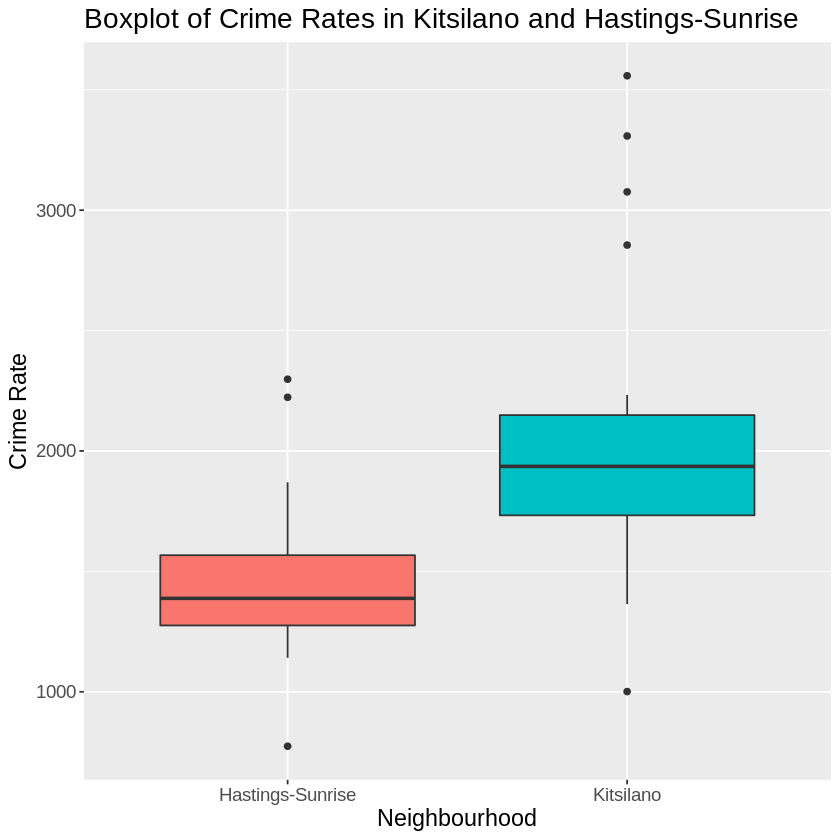

In [5]:
# Plot a boxplot of the crime rates in Kitsilano and Hastings-Sunrise
crime_graph <- crime_data %>% 
    ggplot() +
    geom_boxplot(aes(x = NEIGHBOURHOOD, y = n, fill = NEIGHBOURHOOD)) +
    theme(text = element_text(size = 14)) +
    ggtitle("Boxplot of Crime Rates in Kitsilano and Hastings-Sunrise") + 
    xlab("Neighbourhood") + 
    ylab("Crime Rate") + 
    guides(fill = FALSE)
crime_graph

In [6]:
# Plot density curves for yearly crime rates in Kitsilano and Hastings-Sunrise
crime_data_distribution <-
    crime_data %>%
    ggplot() +
    geom_density(aes(x = n, colour = NEIGHBOURHOOD)) +
    theme(text = element_text(size = 14)) +
    ggtitle("Distribution of Crime Rates in Kitsilano and Hastings-Sunrise") + 
    xlab("Yearly Crime Rate") + 
    ylab("Density")

options(repr.plot.length = 4, repr.plot.width = 10)


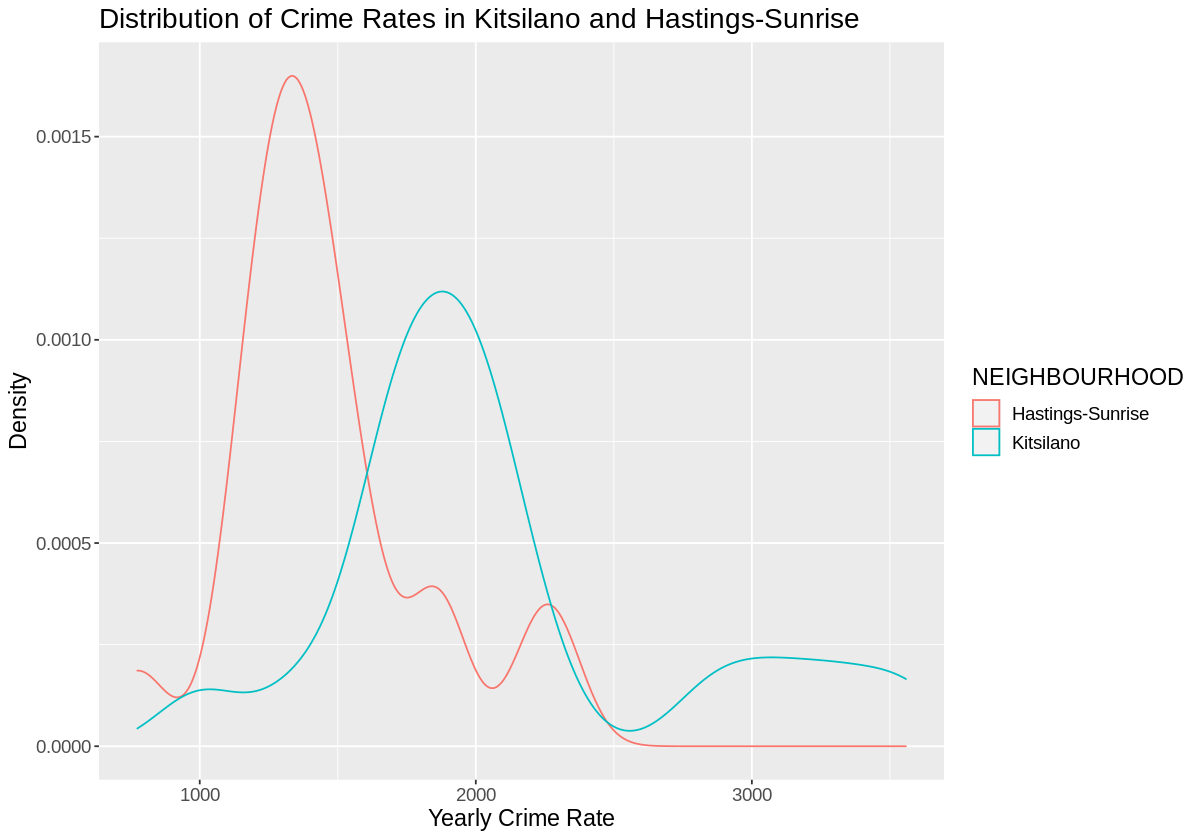

In [7]:
crime_data_distribution

In [8]:
# Calculating difference by grouping filtered data by year, calculating the crime rate for each neighbourhood, and taking the difference.
crime_data_difference <- filtered_crime %>%
    group_by(YEAR) %>%
    summarise(Kitsilano = sum(NEIGHBOURHOOD == 'Kitsilano'),
              Hastings_Sunrise = sum(NEIGHBOURHOOD == 'Hastings-Sunrise'),
             Difference = Kitsilano - Hastings_Sunrise)

In [9]:
head(crime_data_difference)

YEAR,Kitsilano,Hastings_Sunrise,Difference
<dbl>,<int>,<int>,<int>
2003,3558,2223,1335
2004,3308,2298,1010
2005,3076,1870,1206
2006,2855,1851,1004
2007,2233,1549,684
2008,2010,1450,560


In [10]:
# Now we can use crime_data_difference to plot the distribution of differences
difference_distribution <-
    crime_data_difference %>%
    ggplot() +
    geom_density(aes(x = Difference)) +
    theme(text = element_text(size = 14)) +
    ggtitle("Distribution of Difference of Crime Rates Between Kitsilano and Hastings-Sunrise") + 
    xlab("Difference of Crime Rates By Year") + 
    ylab("Density")

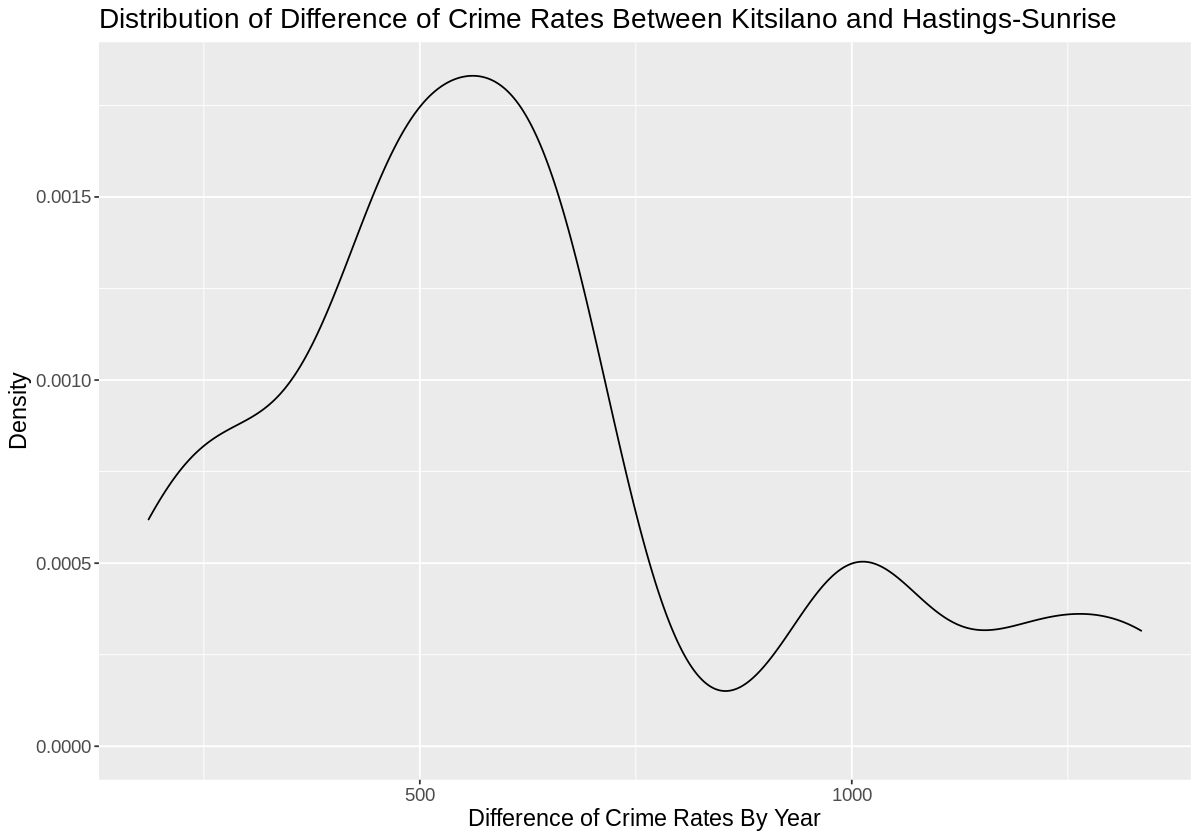

In [11]:
difference_distribution

In [12]:
crime_data_difference

YEAR,Kitsilano,Hastings_Sunrise,Difference
<dbl>,<int>,<int>,<int>
2003,3558,2223,1335
2004,3308,2298,1010
2005,3076,1870,1206
2006,2855,1851,1004
2007,2233,1549,684
2008,2010,1450,560
2009,2016,1376,640
2010,1743,1253,490
2011,1647,1316,331


## Results

In [16]:
t_test <-tidy(
  t.test(x = crime_data_difference$Difference,
         mu = 0,
         alternative = 'two.sided',
         conf.level = 0.99)
)

In [17]:
t_test

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
616.05,8.909231,3.268904e-08,19,418.2239,813.8761,One Sample t-test,two.sided


In [18]:
t_graph <- ggplot(data.frame(x = c(-10, 10)), aes(x = x)) +
        stat_function(fun = dt, args = list(df = 19)) +
        geom_vline(xintercept = t_test$statistic, colour = 'red') +
        labs(x = 't-value', y = 'Density', title = "Student's t-distribution (df = 19)", subtitle = 'Red line represents test statistic')

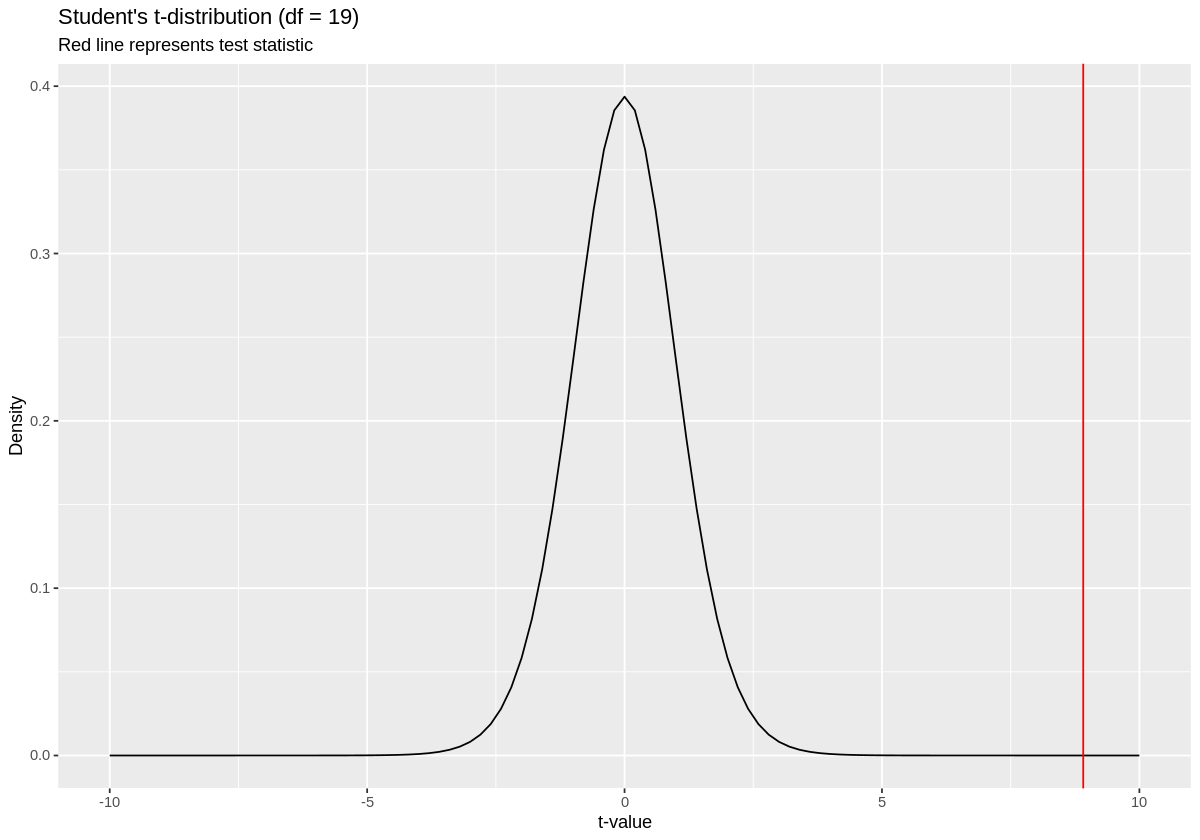

In [19]:
t_graph

## Discussion

## References

[1] (2022) VPD open data. Available at: https://geodash.vpd.ca/opendata/# (Accessed: October 25, 2022). 

[2] Daflos, P. (2022) Is Vancouver 'deteriorating'? how public safety is being debated in the lead-up to the election, British Columbia. CTV News. Available at: https://bc.ctvnews.ca/is-vancouver-deteriorating-how-public-safety-is-being-debated-in-the-lead-up-to-the-election-1.6103614 (Accessed: November 2, 2022). 